In [86]:
import numpy as np
import os
import sys
import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [87]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU.


<h1> Train a convolutional neural network that can classify single digits

<li>First training a CNN that can identify digits (if they are present).</li>
<li>We use CIFAR10 to train the network on non digit images.</li>
<li>The non digit class is represented by 10

In [184]:
batch_size = 64
size = 32

transformer_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5], [.5,.5,.5])
])

transformer_cifar = transforms.Compose([
    transforms.RandomResizedCrop((size,size)),
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5], [.5,.5,.5])
])

# loading SVHN
svhn = datasets.SVHN('./data', download=True, transform=transformer_svhn)
svhn_loader = DataLoader(svhn, batch_size=batch_size, shuffle=True, num_workers=3)

# loading CIFAR10
cifar = datasets.CIFAR10("./data", download=True, transform=transformer_cifar)
cifar.targets = [10] * len(cifar.targets) #switching all label to 10, meaning "no digit"
cifar_loader = DataLoader(cifar, batch_size=batch_size, shuffle=True, num_workers=3)

Using downloaded and verified file: ./data/train_32x32.mat
Files already downloaded and verified


In [185]:
print("Length CIFAR10: {}".format(len(cifar_loader.dataset)))
print("Length SVHN: {}".format(len(svhn_loader.dataset)))

Length CIFAR10: 50000
Length SVHN: 73257


In [186]:
# concatenating both dataset in order to create the training set
train_set = cifar + svhn
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

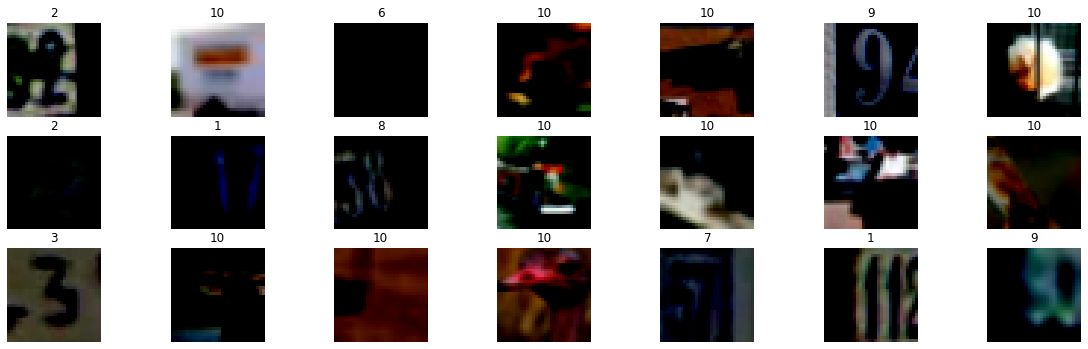

In [187]:
# ploting images of the dataset
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(range(11)[labels[i].item()])
    plt.axis('off')

In [92]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU())

        self.fully_connected = nn.Sequential(
            nn.Conv2d(32,500, kernel_size=16),
            nn.ReLU(),
            nn.Conv2d(500, 500, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(500, 11, kernel_size=1),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = self.fully_connected(x)
        return x

In [93]:
def train_digit_classifier(model, optimizer, num_epochs=5):
    train_acc_all = []
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        train_correct = 0
        
        model.train()
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data = data.to(device)
#             print("----------------------------------")
#             print(target)
            target = target.to(device)
            
            # set the parameter gradients to zero
            optimizer.zero_grad()
            
            output = model(data).squeeze()
            
            loss_size = F.nll_loss(torch.log(output), target)
            loss_size.backward()
            optimizer.step()
            
            predicted = output.argmax(1)
#             print(predicted)
            train_correct += (target==predicted).sum().item()
        
        train_acc = train_correct / len(train_set)
        train_acc_all.append(train_acc)
        print("Training accuracy: {}%".format(100*train_acc))
    
    return train_acc_all

In [188]:
model = Network()
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=.01)

train_acc = train_digit_classifier(model, optimizer, num_epochs=20)

torch.save(model.state_dict(), "digit_classifier.pth")

Training accuracy: 42.23938599836114%


Training accuracy: 53.483372141136%


Training accuracy: 63.2077691327876%


Training accuracy: 71.42069010279334%


Training accuracy: 77.03984357886368%


Training accuracy: 81.41687693193896%


Training accuracy: 87.2404812708406%


Training accuracy: 89.45455430523216%


Training accuracy: 91.02931273680197%


Training accuracy: 92.07996300412958%


Training accuracy: 93.11357569955459%


Training accuracy: 93.80238039218868%


Training accuracy: 94.47171357407693%


Training accuracy: 95.02827425622885%


Training accuracy: 95.64730603535702%


Training accuracy: 96.10001866019779%


Training accuracy: 96.55191997209084%


Training accuracy: 96.95514250711928%


Training accuracy: 97.41515694848974%


Training accuracy: 97.74941788296%



<hr>

<h1> Implementation of digit detection

Loading data of digit detection

In [189]:
class SVHN_(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/SVHN'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        list_files = os.listdir(data_path)
        self.image_paths = [os.path.join(data_path, file) for file in list_files]
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        X = self.transform(image)
        return X

In [265]:
size=200

# transformer_svhn_train = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([.5,.5,.5], [.5,.5,.5])
# ])

transformer_svhn_test = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5], [.5,.5,.5])
])

# SVHN_train = SVHN_(train=True, transform=transformer_svhn_train)
# SVHN_train_loader = DataLoader(SVHN_train, batch_size=batch_size, shuffle=True, num_workers=3)
SVHN_test = SVHN_(train=False, transform=transformer_svhn_test)
SVHN_test_loader = DataLoader(SVHN_test, batch_size=batch_size, shuffle=True, num_workers=3)

<hr>

In [225]:
def get_box_boundaries_around_digits(tensor_image, predictions):
    '''Return the box boundaries of windows that contain images'''
    _, b, h = tensor_image.squeeze().shape
    list_predictions = predictions.tolist()[0]
    list_predictions = [item for sublists in list_predictions for item in sublists]
    b_window = 32
    h_window = 32
    
    coordinates = []
    predicts = []
    index = 0
    for y in range(h_window, h, 2):
        for x in range(b_window, b, 2):
            prediction = list_predictions[index]
            if prediction != 10:
                x_left, x_right = x - b_window, x
                x_right = x
                y_top = y - h_window
                y_bottom = y
                coordinates.append((x_left, x_right, y_top, y_bottom))
                predicts.append(prediction)
            index += 1
    
    return coordinates, predicts

In [226]:
def iou(coord_box1, coord_box2):
    '''Function returning the Jaccard index of two bounding box
    Parameters: tuples containing the positions of the box corner'''
    x_left1, x_right1, y_top1, y_bottom1 = coord_box1
    x_left2, x_right2, y_top2, y_bottom2 = coord_box2
    
    dx = min(x_right1, x_right2) - max(x_left1, x_left2)
    dy = min(y_bottom1, y_bottom2) - max(y_top1, y_top2)

    if (dx >= 0) and (dy >= 0):
        intersection = dx * dy
    else:
        intersection = 0
      
    area1 = (x_right1 - x_left1) * (y_bottom1 - y_top1)
    area2 = (x_right2 - x_left2) * (y_bottom2 - y_top2)
    union = area1 + area2 - intersection 
    
    return intersection / union

In [260]:
def nms(coord, labels, scores, threshold=.5):
    '''Implementation of Non-Max suppression'''
    coord_nms = []
    for i in range(len(coord)):
        if labels[i] == 10: # we do not pay attention to background
            continue
            
        discard = False 
        for j in range(len(coord)):
            if (labels[i] == labels[j]) and (j != i):
                iou_ = iou(coord[i], coord[j])
                if iou_ > threshold:
                    if scores[j] > scores[i]:
                        discard = True
                        
        if not discard and scores[i] > .9:
            coord_nms.append((coord[i], labels[i]))

    return coord_nms

Loading model

In [261]:
torch.cuda.empty_cache() # freeing reusable memory

model = Network()
model.to(device)
model.load_state_dict(torch.load("digit_classifier.pth"));

Feeding the model with one image

In [286]:
# loading random image from the test loader and converting it to 
# a batch to be able to put it in the mode
image = next(iter(SVHN_test_loader))[0]
image_tensor = image.unsqueeze(0)
image_tensor = image_tensor.to(device)

model.eval()
output = model(image_tensor)

In [287]:
# applying IoU with a suitable threshold to find a digit correct.
coord_, labels_ = get_box_boundaries_around_digits(image_tensor, output.argmax(1))

scores_ = output.max(1).values
scores_ = scores_.tolist()[0]
scores_ = [item for sublists in scores_ for item in sublists]

final_coord = nms(coord_, labels_, scores_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


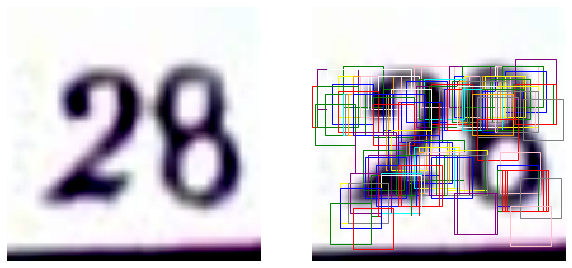

In [288]:
color_rectangle = {
    0: "yellow", 1: "green", 2: "blue", 3: "pink", 4: "red",
    5: "white", 6: "cyan", 7: "purple", 8: "orange", 9: "grey"
}

f = plt.figure(figsize=(10,5))
plt.tight_layout()

ax = f.add_subplot(121)
ax.imshow(np.swapaxes(np.swapaxes(image.numpy(), 0, 2), 0, 1))
ax.axis("off")

ax2 = f.add_subplot(122)
ax2.imshow(np.swapaxes(np.swapaxes(image.numpy(), 0, 2), 0, 1))
ax2.axis("off")

for coord, label in final_coord:
    x_left, x_right, y_top, y_bottom = coord
    rect = patches.Rectangle((x_left,y_top),32,32,linewidth=1,edgecolor=color_rectangle[label],facecolor='none')
    ax2.add_patch(rect)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


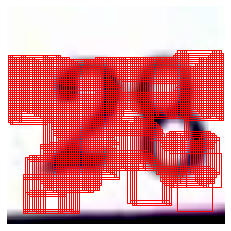

In [289]:
fig, ax = plt.subplots(1)

ax.imshow(np.swapaxes(np.swapaxes(image.numpy(), 0, 2), 0, 1))
ax.axis("off")

for elt in coord_:
    x_left, x_right, y_top, y_bottom = elt
    rect = patches.Rectangle((x_left,y_top),32,32,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)